# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 3</span>

### <font color="teal">Exercise 03.1 

#### <font color="teal">Plain vanilla option pricing

The aim of this exercise is to compute the European ("plain vanilla") call-option and put-option prices at time $t=0$.

Options are financial contracts that give the option buyer the right, but not the obligation, to buy (call-option) or to sell (put-option) an asset at a specified price $K$ within a specific time period $T$. A call buyer profits when the asset increases in price, whereas a put buyer profits when the asset decreases in price:
- call-option: $profit_{call} = max[0,S(T)-K]$;
- put-option: $profit_{put} = max[0,K-S(T)]$.

The option price at $t=0$ must be the present value of the profit, which is the expected value of the profit set back to the time of the contract stipulation on the distribution of the prices at expiry:
- call-option price: $C[S(0),0]= \langle e^{-rT}max[0,S(T) - K] \rangle$;
- put-option price: $P[S(0),0]= \langle e^{-rT}max[0,K - S(T)] \rangle$;

where the discount factor $e^{-rT}$ is due to the interest that a bank would have guaranteed with a deposit at time $t=0$. This quantity is, in fact, the estimate of what the holder of the option have to pay at $t=0$ on the basis of the expected profit at time $t=T$.

Thus, to obtain call-option and put-option prices at time $t=0$, we first have to compute the asset price $S(T)$.

**Black-Scholes analytic solution**

Black-Scholes theory assumes that the time evolution of the asset price is stochastic and exhibits geometric Brownian motion (GBM) with constant risk-free interest rate $r$ and volatility $\sigma$.

The Black-Scholes analytic solution for the price at time t<T is:
- European Call-option price:
$$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$
- European Put-option price:
$$ P\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$

where 
$$d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2} (T-t) \right)\right]$$

where $d_2 = d_1 - \sigma\sqrt{T-t}$, and where
$$ N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$
is the cumulative of Gaussian $\sim \mathcal{N}(\mu=0,\sigma^2=1)$,
and where
$${\rm erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} dz \, e^{-z^2}$$

By using the following parameters: 
- asset price at $t=0$: $S(0)=100$
- delivery time: $T=1$
- strike price: $K=100$
- risk-free interest rate: $r=0.1$
- volatility: $\sigma=0.25$

the analytic solution is:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.special import erf
from scipy import log, exp, sqrt
from scipy.optimize import curve_fit

In [2]:
#data
S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    call, put = black_scholes(S0, K, T, r, sigma)
    print("== BLACK-SCHOLES ==")
    print("call: C[S(0),0] =", call)
    print("put: P[S(0),0] =", put)

== BLACK-SCHOLES ==
call: C[S(0),0] = 14.975790778311286
put: P[S(0),0] = 5.4595325819072364


**Monte Carlo simulation**

Given that the asset price is $S\sim GBM(r,\sigma^2)$, with initial value $S(0)$, we want to compute the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$ at time $t=0$ via Monte Carlo simulations, using two different methods:

- <span style="color:teal">Direct sampling</span>
<br />By sampling directly the final asset price:
$$S(T) = S(0) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)T+\sigma W(T)\right]$$
where $W(T)\sim\mathcal{N}(0,T)$.


- <span style="color:teal">Discretized sampling</span>
<br />By sampling the discretized $GBM(r,\sigma^2)$ path of the asset price dividing $[0,T]$ in $n=100$ time intervals: $S(0)$, $S(t_1)$, $S(t_2)$,..., $S(t_{100}=T)$.
Since the increments of $W$ are independent and normally distributed, the recursive procedure for sampling discretized values of $S\sim GBM(r,\sigma^2)$ at $t_1 < t_2 < … < t_n$ is:
$$S(t_{i+1}) = S(t_i) \exp\left[ \left(r-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)
    +\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$
with $Z_i \sim \mathcal{N}(0,1)$


We estimate $C[S(0),0]$ and $P[S(0),0]$ with the direct and discretized sampling methods, with a large number ($M=10^5$) of asset prices at time $t=T$, as a function of $M$. We also compute statistical uncertainties using the data blocking method. We use the same parameters listed above for computing the analytic solution.

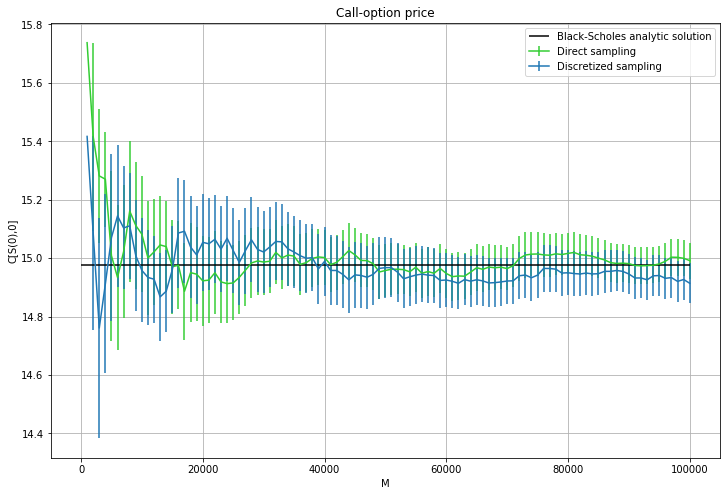

In [3]:
x1,y1,err1=np.loadtxt("direct_call.out",usecols=(0,1,2),unpack=True)
x2,y2,err2=np.loadtxt("discrete_call.out",usecols=(0,1,2),unpack=True)

fig=plt.figure(figsize=(12, 8))
plt.errorbar(x1,y1,yerr=err1, color='limegreen', label="Direct sampling")
plt.errorbar(x2,y2,yerr=err2, label="Discretized sampling")
plt.hlines(call, 0, 100000, label="Black-Scholes analytic solution")
plt.title('Call-option price')
plt.xlabel('M')
plt.ylabel('C[S(0),0]')
plt.grid(True) 
plt.legend()

plt.show()

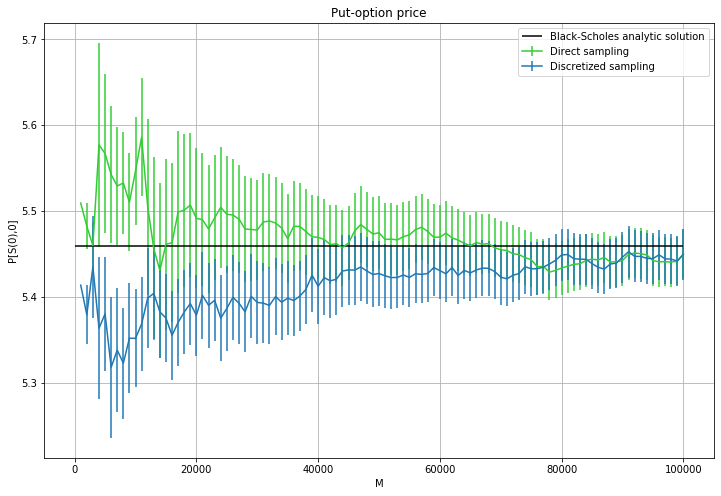

In [4]:
x1,y1,err1=np.loadtxt("direct_put.out",usecols=(0,1,2),unpack=True)
x2,y2,err2=np.loadtxt("discrete_put.out",usecols=(0,1,2),unpack=True)

fig=plt.figure(figsize=(12, 8))
plt.errorbar(x1,y1,yerr=err1, color='limegreen', label="Direct sampling")
plt.errorbar(x2,y2,yerr=err2, label="Discretized sampling")
plt.hlines(put, 0, 100000, label="Black-Scholes analytic solution")
plt.title('Put-option price')
plt.xlabel('M')
plt.ylabel('P[S(0),0]')
plt.grid(True) 
plt.legend()

plt.show()

Call-option and put-option prices estimation obtained with both the two sampling methods (direct and discretized) converge to the Black-Scholes analytic solutions.